# Quantum Teleportation
This script teleports an arbitrary state from one qbit to another using the well-known teleportation protocol. Single qbit tomography and readout calibration are used to reconstruct the output state, in order to compare with the expected result.

In [1]:
#importing necessary modules
import numpy as np
import pandas as pd
import random
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
%matplotlib inline

# qiskit modules
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector, plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity, DensityMatrix

# tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# readout calibration
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [9]:
# importing IBMQ backends
from qiskit import IBMQ
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
device = ibmq_provider.get_backend('ibmq_16_melbourne')

# necessary imports for noise modelling
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
basis_gates = noise_model.basis_gates

Credentials are already in use. The existing account in the session will be replaced.


### Defining the expected state

In [ ]:
R=[]
for i in range(3):
    R.append(10*random.random()) 

qreg = QuantumRegister(3)
qreg_exp = QuantumRegister(1)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.rx(np.pi/5*R[0],0)
qc_expected.ry(np.pi/5*R[1],0)
qc_expected.rz(np.pi/5*R[2],0)
qc_expected.draw(output='mpl')

In [ ]:
# visualizing the expected state on the Bloch sphere
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_bloch_multivector(psi_expected)

In [ ]:
# plotting the density matrix
plot_state_city(psi_expected, title='Expected state')

### Defining the circuit

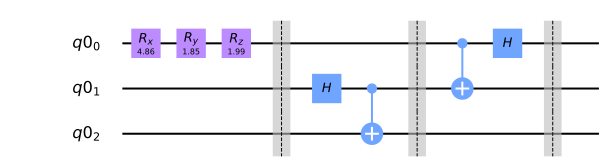

In [3]:
qc = QuantumCircuit(qreg)
qc.rx(np.pi/5*R[0],0)
qc.ry(np.pi/5*R[1],0)
qc.rz(np.pi/5*R[2],0)
qc.barrier()
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.draw(output='mpl')

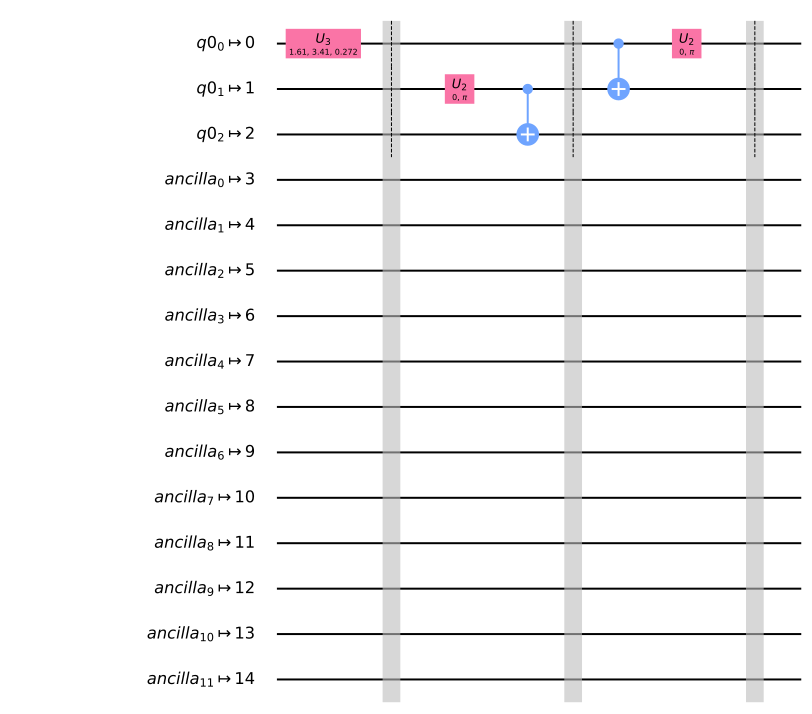

In [10]:
# what does this circuit look like on the device?
transpile_qc = qiskit.compiler.transpile(qc,device)
transpile_qc.draw(output='mpl')

### Readout correction
This is done by initializing the three qbits in all eight combinations of 000, 001, etc and measuring the output to estimate the likelihood of a bit flip.

In [ ]:
#readout calibration measurements
cal_circuits, state_labels = complete_meas_cal(qr = qc.qregs[0], circlabel = 'measerrormitcal')
cal_job = qiskit.execute(cal_circuits,backend = device,shots = 8192, optimization_level = 0)
job_monitor(cal_job)
calres = cal_job.result()
meas_fitter = CompleteMeasFitter(calres, state_labels)
meas_fitter.plot_calibration()

In [ ]:
# post-processing for finding the readout error correction
counts = [0,0,0,0,0,0,0,0]
bits = ['000', '100', '001', '101', '010', '110', '011', '111']
for i in range(8):
    counts[i] = calres.get_counts(cal_circuits[i])
    for bit in bits:
        if bit not in counts[i]:
            counts[i][bit] = 0

m0 = 0
m1 = 0
for i in range(8):
    for num, bit in enumerate(bits):
        if num%2 == 0 and i < 4:
            m0 += float(counts[i][bit]) / (8192*4)
        if num%2 == 1 and i < 4:
            m0 -= float(counts[i][bit]) / (8192*4)
        if num%2 == 1 and i > 3:
            m1 -= float(counts[i][bit]) / (8192*4)
        if num%2 == 0 and i > 3:
            m1 += float(counts[i][bit]) / (8192*4)
            
beta0 = float(m0 + m1) / 2
beta1 = float(m0 - m1) / 2
print('The value of beta 0:', beta0)
print('The value of beta 1:', beta1)

cons_F = beta1
F_aa = 1/2 + beta1 /2
print('The conservative fidelity is:', cons_F)
print('The average assignment fidelity is:', F_aa)

### State Tomography
In order to reconstruct the output state of the circuit, it is necessary to perform single qbit tomography to build up the state we have from a large number of measurements in the 3 cardinal bases.

In [ ]:
# defining the tomography circuits
qst_full_circuits = state_tomography_circuits(qc,qreg)
# the three circuits are in the order [ZZX, ZZY, ZZZ]
qst_circuit = [qst_full_circuits[24], qst_full_circuits[25], qst_full_circuits[26]]

In [ ]:
paulis = [('Z','Z','X'), ('Z','Z','Y'), ('Z','Z','Z')]
basis = ['X', 'Y', 'Z']
backends = ['simulator', 'simulator_noise', device]

for num, backend in enumerate(backends):
    state = {'X': {'0': 0, '1': 0}, 'Y': {'0': 0, '1': 0}, 'Z': {'0': 0, '1': 0}}
    state_df = pd.DataFrame(data=[state,state,state,state])
    if num == 0:
        job_sim = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 1:
        job_sim = qiskit.execute(qst_circuit, Aer.get_backend('qasm_simulator'), shots=8192,
                                 noise_model=noise_model, 
                                 coupling_map=coupling_map, 
                                 basis_gates=basis_gates)
        tom = StateTomographyFitter(job_sim.result(), qst_circuit)
    if num == 2:
        job_dev = qiskit.execute(qst_circuit, backend, shots=8192)
        job_monitor(job_dev)
        tom = StateTomographyFitter(job_dev.result(), qst_circuit)
    for pauli in paulis:
        for bit in bits:
            if bit not in tom.data[pauli]:
                tom.data[pauli][bit]=0
                
    # 4 possible outcomes of teleport protocol, where the final state is either
    # psi, X @ psi, Z @ psi, X @ Z @ psi. We store all 4 seperately, to then transform
    # the resulting density matrices appropriately before finding fidelity
    for i in range(4):
        for j in range(3):
            state_df.loc[i][basis[j]] = {'0': tom.data[(paulis[j])][bits[2*i]],
                                         '1': tom.data[(paulis[j])][bits[2*i+1]]}
    
    if num == 0:
        state_sim = state_df
        print('The full state for the simulator is', state_sim)
    if num == 1:
        state_sim_noise = state_df
        print('The full state for the noisy simulator is', state_sim_noise)
    if num == 2:
        state_dev = state_df
        print('The full state for the device is', state_dev)

In [ ]:
# defining the matrices to reconstruct the density matrices
Iden = np.matrix('1, 0; 0, 1')
XPaul = np.matrix('0, 1; 1, 0')
YPaul = np.matrix('0, 0-1j; 0+1j, 0')
ZPaul = np.matrix('1, 0; 0, -1')

state_tot=[state_sim,state_sim_noise,state_dev]
rho = [0,0,0,0]
r_tot = np.zeros((4,3))
for num, states in enumerate(state_tot):
    rho_tot=[0,0,0,0]
    for i in range(4):
        for j in range(3):
            r_tot[i,j] = (states[basis[j]][i]['0']*1 + states[basis[j]][i]['1']*(-1)) \
                        /(states[basis[j]][i]['0'] + states[basis[j]][i]['1'])
    for i in range(4):
        rho_tot[i] = (1/2)*(Iden+r_tot[i,0]*XPaul+r_tot[i,1]*YPaul+r_tot[i,2]*ZPaul)
    rho[num] = rho_tot

r_tot[:,:] = (r_tot[:,:] - beta0) / beta1
rho_corr = [0,0,0,0]
for i in range(4):
        rho_corr[i] = (1/2)*(Iden+r_tot[i,0]*XPaul+r_tot[i,1]*YPaul+r_tot[i,2]*ZPaul)
rho[3] = rho_corr

for ind in range(4):
    rho[ind][1] = ZPaul @ rho[ind][1] @ ZPaul
    rho[ind][2] = XPaul @ rho[ind][2] @ XPaul
    rho[ind][3] = ZPaul @ XPaul @ rho[ind][3] @ XPaul @ ZPaul
    
# finding the average density matrix from the four possible outcomes
rho_avg = [0,0,0,0]
for i in range(4):
    rho_avg[i] = np.mean(np.array([rho[i][0], rho[i][1], rho[i][2], rho[i][3]]), axis=0)

### Calculating Fidelities

In [ ]:
F_avg = [0,0,0,0]
for i in range(4):
    F_avg[i] = state_fidelity(psi_expected, rho_avg[i], validate=False)
    
print('Simulator Fidelity:', F_avg[0])
print('Noisy Simulator Fidelity:', F_avg[1])
print('Device Fidelity:', F_avg[2])
print('Calibrated Device Fidelity', F_avg[3])

In [ ]:
# Fidelity = np.zeros((4,4))
# for i in range(4):
#     for j in range(4):
#         Fidelity[i,j] = state_fidelity(psi_expected, rho[i][j], validate=False)     

# print(Fidelity)
# F = np.mean(Fidelity,axis=1)
# print('Simulator Fidelity:', F[0])
# print('Noisy Simulator Fidelity:', F[1])
# print('Device Fidelity:', F[2])
# print('Corrected Device Fidelity:', F[3])

In [ ]:
plot_state_city(rho[0][0], title='Simulator Density Matrix')

In [ ]:
plot_state_city(rho[1][0], title='Noisy Simulator Density Matrix')

In [ ]:
plot_state_city(rho[2][0], title='Device Density Matrix')

In [ ]:
plot_state_city(rho[3][0], title='Device Corrected Density Matrix')

In [ ]:
# checking validity of the density matrices
# rho_sim = DensityMatrix(rho[0][0])
# rho_dev = DensityMatrix(rho[2][0])
# print('Is the simulator density matrix valid?', rho_sim.is_valid())
# print('Is the device density matrix valid?', rho_dev.is_valid())

print('Is the simulator density matrix valid?', DensityMatrix(rho_avg[0]).is_valid())
print('Is the device density matrix valid?', DensityMatrix(rho_avg[2]).is_valid())

# The simulator makes an impossible density matrix, which is to be
# expected for a finite number of runs of a circuit

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table